# Capstone Project - Predicting Laser Attacks on Aircraft

In [1]:
import pandas as pd
import time
import urllib.request, urllib.parse, urllib.error
import json
import ssl
from timezonefinder import TimezoneFinder
from datetime import datetime

#### Import the Data from the Spreadsheet and read into a Pandas Dataframe

In [2]:
df = pd.read_excel('1.xls', sheet_name="Laser Report 2014")

After some trial and error I decided to use the Google Maps API to collect Lat and Long data from each City listed in the Dataframe. This function returns the coordinates for a string input of town.

In [3]:
def getlatlon(location):
    api_key = "Insert Your Own API Key Here"
    google_url = "https://maps.googleapis.com/maps/api/geocode/json?"
    parms = {}
    parms['address'] = location
    parms['key'] = api_key
    url = google_url + urllib.parse.urlencode(parms)
    uh = urllib.request.urlopen(url)
    data = uh.read().decode()
    try:
        js = json.loads(data)
    except:
        js = None
    try:
        lat = js['results'][0]['geometry']['location']['lat']
        lng = js['results'][0]['geometry']['location']['lng']
    except:
        lat = ""
        lng = ""
    return '{},{}'.format(lat, lng)

getlatlon('Washington, DC')

'38.9071923,-77.0368707'

This converts the location to lower case as there were a few combinations of Upper and Lower case used, it then combines it into one string ready for passing to the lat/lon getter function.

In [4]:
df['location'] = df.CITY.str.lower() + ", " + df.STATE.str.lower()

In [5]:
df.head()

DATE      TIME Aircraft ID  No. A/C TYPE A/C    ALT MAJOR CITY  COLOR  \
0 2014-01-01  00:08:00     CHQ6045        1     E145   8000        CAE  Green   
1 2014-01-01  00:35:00         PSA        1     CRJ2   2100        PHL  Green   
2 2014-01-01  02:02:00      SWA563        1     B737   4200        PHX  Green   
3 2014-01-01  02:35:00     RPA3242        1     E175  FL240        EWR  Green   
4 2014-01-01  02:59:00     AAL1153        1     B738  12000        POM  Green   

  Injury Reported          CITY           STATE                    location  
0              NO      Columbia  South Carolina    columbia, south carolina  
1              NO  Philadelphia    Pennsylvania  philadelphia, pennsylvania  
2              NO       Phoenix         Arizona            phoenix, arizona  
3              NO       Newark      New Jersey         newark , new jersey   
4              NO        Pomona      California          pomona, california

To avoid multiple API requests for the same location I created a frame of unique locations then passed that into a regular Python list ready for processing

In [6]:
locationlist = pd.DataFrame(df['location'].unique())
locationlist.columns = ['location']
locationlist = locationlist.dropna(axis=0)
location_pylist = locationlist['location'].values.tolist()

In [8]:
len(location_pylist)

673

The next two cells initialise an empty list and fill the list with dictionaries of location data. The function checks to see if the location is already in the list and if it isn't it goes searching for it.

I've commented the initialiser out to avoid accidentally erasing all the data, it is no longer necessary to run these cells as I saved the location data to a CSV to avoid using the location API over and over.

In [9]:
# location_list = []

In [294]:
counter = 0
for location in location_pylist:
    found = False
    for dic in location_list:
        if location in dic.values():
            found = True
            # print(location + 'already found')
            continue
    if found == False :
        print('Processing:' + location)
        lat_long = getlatlon(location)
        if lat_long != None:
            if counter % 10 == 0 :
                time.sleep(10)
            location_dic = {}
            loclist = lat_long.split(',')
            lat = loclist[0]
            lon = loclist[1]
            location_dic['location'] = location
            location_dic['lat'] = lat
            location_dic['lon'] = lon
            location_dic['zone'] = get_timezone(lat, lon)
            location_list.append(location_dic)
            counter += 1
        
        


In [281]:
# locations_frame = pd.DataFrame(location_list)
# locations_frame.to_csv(r'locations.csv', index = False, header=True)

This loads the location data I processed previously and saved.

In [10]:
loc_merge_frame = pd.read_csv('locations.csv')

In [11]:
loc_merge_frame.head()

location        lat         lon                 zone
0    columbia, south carolina  34.000749  -81.034331     America/New_York
1  philadelphia, pennsylvania  39.952724  -75.163526     America/New_York
2            phoenix, arizona  33.448437 -112.074142      America/Phoenix
3        newark , new jersey   40.735657  -74.172367     America/New_York
4          pomona, california  34.055381 -117.751750  America/Los_Angeles

In [15]:
location_list = loc_merge_frame['location'].values.tolist()
len(location_list)

673

We now import folium to visualise the location coordinates on a map.

In [16]:
import folium


In [757]:
locations = loc_merge_frame[['lat', 'lon']]
locations = locations.dropna()
locationlist = locations.values.tolist()
for location in locationlist:
    if location[0] != '':
        location[0] = float(location[0])
        location[1] = float(location[1])

In [25]:
fol_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
for i in range(len(locationlist)):
    if locationlist[i][0] != '':
        folium.CircleMarker(locationlist[i], radius=2).add_to(fol_map)

In [26]:
fol_map

We have the locations and lat/longs - what is needed is to merge this back into the original dataframe so that we have the coordinates for all the locations.

In [27]:
loc_merge_frame.head()

location        lat         lon                 zone
0    columbia, south carolina  34.000749  -81.034331     America/New_York
1  philadelphia, pennsylvania  39.952724  -75.163526     America/New_York
2            phoenix, arizona  33.448437 -112.074142      America/Phoenix
3        newark , new jersey   40.735657  -74.172367     America/New_York
4          pomona, california  34.055381 -117.751750  America/Los_Angeles

In [28]:
df = df.merge(loc_merge_frame, on='location')

In [29]:
df.drop('location', axis = 1, inplace = True)

In [30]:
df.head()

DATE      TIME Aircraft ID  No. A/C TYPE A/C   ALT MAJOR CITY  COLOR  \
0 2014-01-01  00:08:00     CHQ6045        1     E145  8000        CAE  Green   
1 2014-01-30  04:01:00      R95648        1     HELO  1500        CAE  Green   
2 2014-06-01  02:14:00     ASQ5702        1     CRJ2  3000        CAE  Green   
3 2014-01-01  00:35:00         PSA        1     CRJ2  2100        PHL  Green   
4 2014-01-14  04:15:00      AWE558        1     A319  4000        PHL  Green   

  Injury Reported          CITY           STATE        lat        lon  \
0              NO      Columbia  South Carolina  34.000749 -81.034331   
1              NO      Columbia  South Carolina  34.000749 -81.034331   
2              NO      Columbia  South Carolina  34.000749 -81.034331   
3              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   
4              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   

               zone  
0  America/New_York  
1  America/New_York  
2  America/New_York  
3  America/New_York  
4  America/New_York

We now import the modules for KMeans clustering and view the elbow method to see the most optimal k

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [32]:
loc_df = df[['lat', 'lon']]
loc_df.shape
loc_df = loc_df.dropna()

In [33]:
inertia_list = []
x = range(1,21)
for i in x:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(loc_df)
    labels = kmeans.predict(loc_df)
    centroids = kmeans.cluster_centers_
    inertia_list.append(kmeans.inertia_)

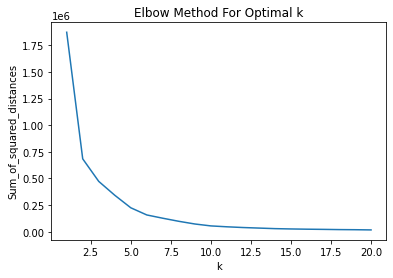

In [34]:
plt.plot(x, inertia_list)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [35]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(loc_df)
labels = kmeans.predict(loc_df)
centroids = kmeans.cluster_centers_


In [36]:
for i in range(len(centroids)):
    folium.CircleMarker(centroids[i], radius=5, color='red').add_to(fol_map)

In [37]:
fol_map

These clusters don't look too bad but the locations outside of the mainland USA are skewing the data, so I decided to filter these out leaving just those on the 48 states.

In [38]:
df_tester = df
df_tester.drop(df_tester[df_tester.lon < -125].index, inplace=True)
df_tester.drop(df_tester[df_tester.lon > -67].index, inplace=True)
df_tester.drop(df_tester[df_tester.lat < 24].index, inplace=True)
df_tester.drop(df_tester[df_tester.lat > 50].index, inplace=True)
df = df_tester

In [39]:
locations = df[['lat', 'lon']]
locations = locations.dropna()
locationlist = locations.values.tolist()
for location in locationlist:
    if location[0] != '':
        location[0] = float(location[0])
        location[1] = float(location[1])

In [40]:
usa_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
for i in range(len(locationlist)):
    if locationlist[i][0] != '':
        folium.CircleMarker(locationlist[i], radius=2).add_to(usa_map)

In [41]:
usa_map

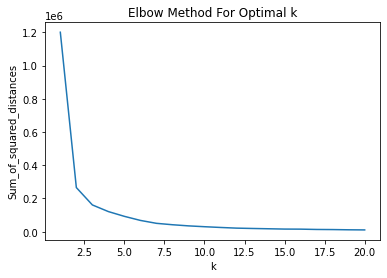

In [42]:
inertia_list = []
x = range(1,21)
for i in x:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(locations)
    labels = kmeans.predict(locations)
    centroids = kmeans.cluster_centers_
    inertia_list.append(kmeans.inertia_)

plt.plot(x, inertia_list)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(locations)
labels = kmeans.predict(locations)
centroids = kmeans.cluster_centers_

In [44]:
for i in range(len(centroids)):
    folium.CircleMarker(centroids[i], radius=5, color='red').add_to(usa_map)

In [45]:
usa_map

These clusterings and locations look much more logical than before.

We now need to convert the Date and Time fields into a useable Pandas Timestamp and extract the Hour from the time.


In [70]:
df['pd_time'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))

In [73]:
df['hour'] = df['pd_time'].dt.hour

In [76]:
df.head()

DATE      TIME Aircraft ID  No. A/C TYPE A/C   ALT MAJOR CITY  COLOR  \
0 2014-01-01  00:08:00     CHQ6045        1     E145  8000        CAE  Green   
1 2014-01-30  04:01:00      R95648        1     HELO  1500        CAE  Green   
2 2014-06-01  02:14:00     ASQ5702        1     CRJ2  3000        CAE  Green   
3 2014-01-01  00:35:00         PSA        1     CRJ2  2100        PHL  Green   
4 2014-01-14  04:15:00      AWE558        1     A319  4000        PHL  Green   

  Injury Reported          CITY           STATE        lat        lon  \
0              NO      Columbia  South Carolina  34.000749 -81.034331   
1              NO      Columbia  South Carolina  34.000749 -81.034331   
2              NO      Columbia  South Carolina  34.000749 -81.034331   
3              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   
4              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   

               zone             pd_time  hour  
0  America/New_York 2014-01-01 00:08:00     0  
1  America/New_York 2014-01-30 04:01:00     4  
2  America/New_York 2014-06-01 02:14:00     2  
3  America/New_York 2014-01-01 00:35:00     0  
4  America/New_York 2014-01-14 04:15:00     4

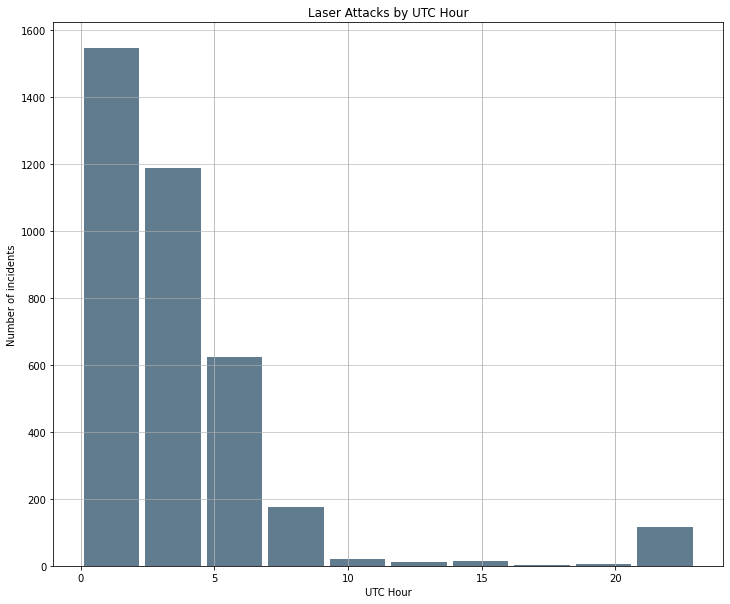

In [218]:
df['hour'].plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e', figsize=(12,10))
plt.title('Laser Attacks by UTC Hour')
plt.xlabel('UTC Hour')
plt.ylabel('Number of incidents')
plt.grid(axis='y', alpha=0.75)

We convert the altitude column to a numeric value

In [78]:
df['ALT'] = pd.to_numeric(df['ALT'], errors='coerce')

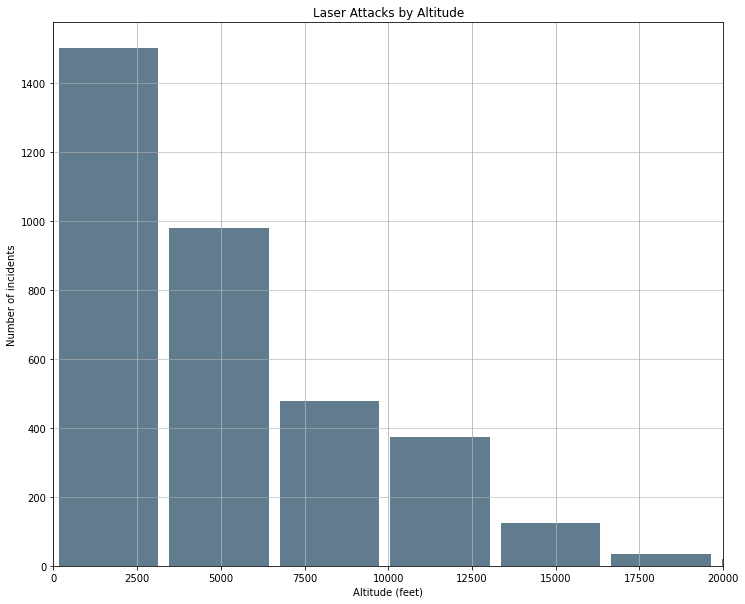

In [213]:
df['ALT'].plot.hist(grid=True, bins=50, rwidth=0.9,
                   color='#607c8e', figsize=(12,10))
plt.title('Laser Attacks by Altitude')
plt.xlabel('Altitude (feet)')
plt.ylabel('Number of incidents')
plt.xlim(right=20000)
plt.xlim(left=0)
plt.grid(axis='y', alpha=0.75)

We now group the States together and plot the top 20

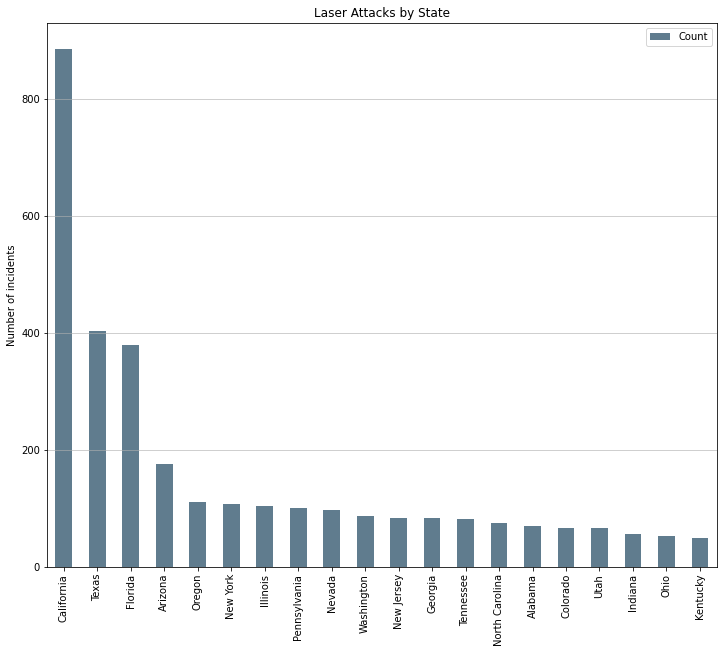

In [755]:
df_state = df.groupby(['STATE']).size().reset_index(name='Count')
top20 = df_state.sort_values(by='Count', ascending=False).head(20)
top20 = top20.set_index('STATE')
top20.plot(kind='bar', figsize = (12,10), color='#607c8e')
plt.title('Laser Attacks by State')
plt.xlabel('')
plt.ylabel('Number of incidents')
plt.grid(axis='y', alpha=0.75)

In [83]:
df['pd_date'] = df['pd_time'].dt.date

In [226]:
df['day_of_week'] = df['pd_time'].dt.day_name()
df['dow_number'] = df['pd_time'].dt.dayofweek
df.head()

DATE      TIME Aircraft ID  No. A/C TYPE A/C     ALT MAJOR CITY  \
0 2014-01-01  00:08:00     CHQ6045        1     E145  8000.0        CAE   
1 2014-01-30  04:01:00      R95648        1     HELO  1500.0        CAE   
2 2014-06-01  02:14:00     ASQ5702        1     CRJ2  3000.0        CAE   
3 2014-01-01  00:35:00         PSA        1     CRJ2  2100.0        PHL   
4 2014-01-14  04:15:00      AWE558        1     A319  4000.0        PHL   

   COLOR Injury Reported          CITY           STATE        lat        lon  \
0  Green              NO      Columbia  South Carolina  34.000749 -81.034331   
1  Green              NO      Columbia  South Carolina  34.000749 -81.034331   
2  Green              NO      Columbia  South Carolina  34.000749 -81.034331   
3  Green              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   
4  Green              NO  Philadelphia    Pennsylvania  39.952724 -75.163526   

               zone             pd_time  hour     pd_date day_of_week  month  \
0  America/New_York 2014-01-01 00:08:00     0  2014-01-01   Wednesday      1   
1  America/New_York 2014-01-30 04:01:00     4  2014-01-30    Thursday      1   
2  America/New_York 2014-06-01 02:14:00     2  2014-06-01      Sunday      6   
3  America/New_York 2014-01-01 00:35:00     0  2014-01-01   Wednesday      1   
4  America/New_York 2014-01-14 04:15:00     4  2014-01-14     Tuesday      1   

   dow_number  
0           2  
1           3  
2           6  
3           2  
4           1

In [186]:
df['month'] = df['pd_time'].dt.month

We now count the number of attacks on each day of the year

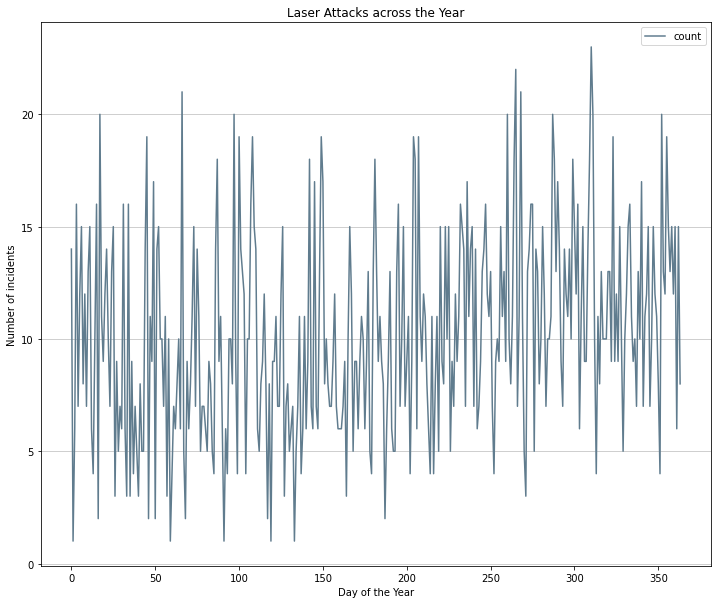

In [197]:
df_date = pd.DataFrame(df['pd_date'].value_counts())
df_date = df_date.reset_index()
df_date.columns = ['date', 'count']
df_date = df_date.sort_values(by=['date'])
df_date = df_date.reset_index(drop=True)
df_date.plot(figsize = (12,10), color='#607c8e', kind='line')
plt.title('Laser Attacks across the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Number of incidents')
plt.grid(axis='y', alpha=0.75)

This is then reduced to counts by month.

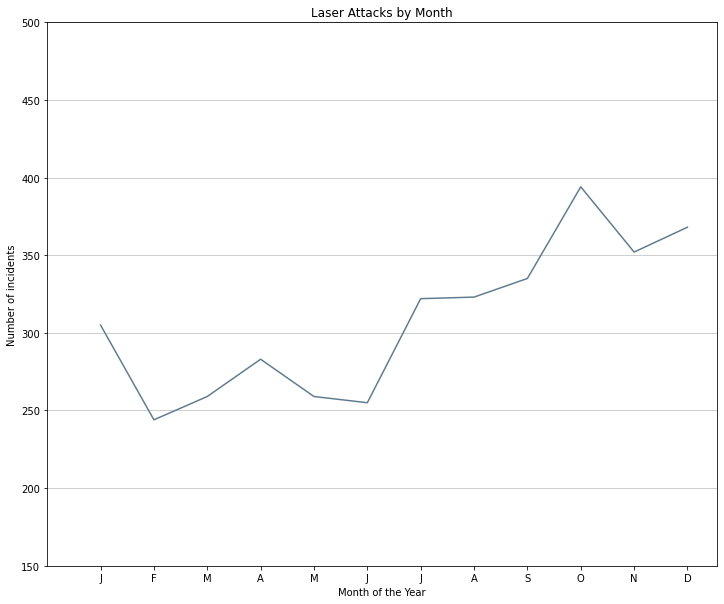

In [212]:
df_month = pd.DataFrame(df['month'].value_counts())
df_month = df_month.reset_index()
df_month.columns = ['month', 'count']
df_month = df_month.sort_values(by=['month'])
df_month = df_month.reset_index(drop=True)
df_month['count'].plot(figsize = (12,10), color='#607c8e', kind='line')
plt.title('Laser Attacks by Month')
plt.xlabel('Month of the Year')
plt.ylabel('Number of incidents')
plt.ylim(top=500)
plt.ylim(bottom=150)
plt.xlim(left=-1)
plt.xticks(np.arange(12), ('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
plt.grid(axis='y', alpha=0.75)

We count the number of attacks by day of the week to see if this has any affect.

In [159]:
df_dow = pd.DataFrame(df['day_of_week'].value_counts())
df_dow = df_dow.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_dow = df_dow.reset_index()
df_dow.columns = ['dow', 'count']
df_dow.head(7)

dow  count
0     Monday    484
1    Tuesday    535
2  Wednesday    496
3   Thursday    453
4     Friday    593
5   Saturday    642
6     Sunday    496

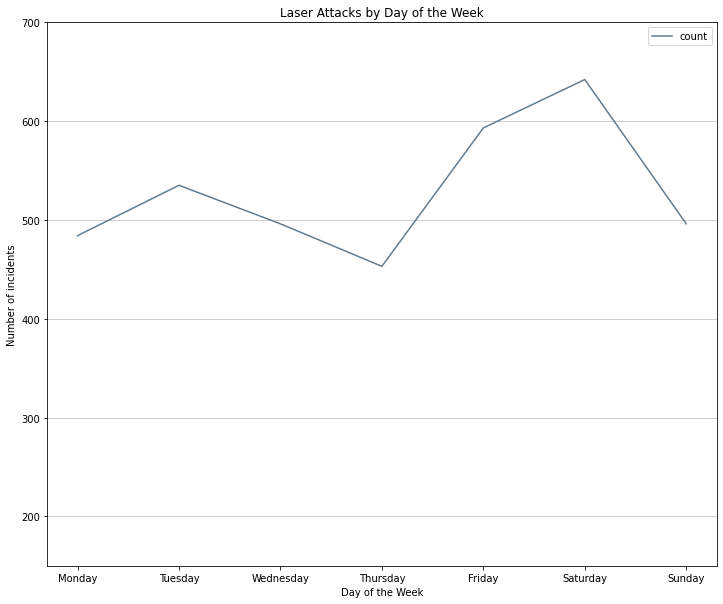

In [214]:
df_dow.plot(figsize = (12,10), color='#607c8e', kind='line')
plt.title('Laser Attacks by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of incidents')
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.ylim(top=700)
plt.ylim(bottom=150)
plt.grid(axis='y', alpha=0.75)

We create a new dataframe that counts the number of attacks by each hour in each state.

In [708]:
df_clean = df[['hour', 'STATE']].copy()
df_clean = df_clean.dropna(axis=0)
df_clean = df_clean.groupby(['hour', 'STATE']).size().reset_index(name='Count')

In [711]:
df_clean.sort_values(by='Count', ascending=False).head(20)

hour       STATE  Count
173     4  California    212
127     3  California    162
217     5  California    161
254     6  California    128
114     2       Texas    108
82      2     Florida     97
68      1       Texas     89
77      2  California     87
41      1     Florida     84
162     3       Texas     70
132     3     Florida     55
280     7  California     53
6       0     Florida     52
206     4       Texas     40
36      1  California     39
125     3     Arizona     37
85      2    Illinois     33
171     4     Arizona     33
75      2     Arizona     33
29      0       Texas     32

For the analysis we create dummy variables for each State.

In [736]:
cat_columns = ['STATE']
df_clean = pd.get_dummies(df_clean, prefix_sep="_",
                              columns=cat_columns)

In [737]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import scipy

In [738]:
X = df_clean[[i for i in list(df_clean.columns) if i != 'Count']]
y = df_clean['Count']
df_clean.head()

hour  Count  STATE_ California  STATE_ District of Columbia  \
0     0      1                  0                            0   
1     0      9                  0                            0   
2     0      2                  0                            0   
3     0      3                  0                            0   
4     0      3                  0                            0   

   STATE_ Florida  STATE_ Indiana  STATE_ Missouri  STATE_ Oklahoma  \
0               0               0                0                1   
1               0               0                0                0   
2               0               0                0                0   
3               0               0                0                0   
4               0               0                0                0   

   STATE_ Oregon  STATE_ Tennessee  ...  STATE_Tennessee  STATE_Texas  \
0              0                 0  ...                0            0   
1              0                 0  ...                0            0   
2              0                 0  ...                0            0   
3              0                 0  ...                0            0   
4              0                 0  ...                0            0   

   STATE_UNKN  STATE_Utah  STATE_Vermont  STATE_Virginia  STATE_Washington  \
0           0           0              0               0                 0   
1           0           0              0               0                 0   
2           0           0              0               0                 0   
3           0           0              0               0                 0   
4           0           0              0               0                 0   

   STATE_Washington   STATE_West Virginia  STATE_Wisconsin  
0                  0                    0                0  
1                  0                    0                0  
2                  0                    0                0  
3                  0                    0                0  
4                  0                    0                0  

[5 rows x 64 columns]

We split the data into test and training sets.

In [684]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

We create a KNN Regressor object and train the data, plotting the test vs predicted values

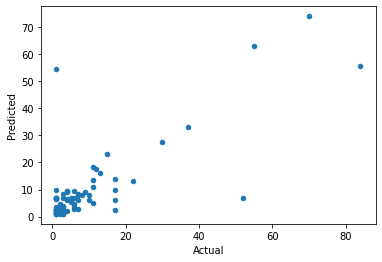

In [691]:
neigh = KNeighborsRegressor(n_neighbors = 2)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.plot(kind='scatter', x='Actual', y='Predicted')


Text(0, 0.5, 'Number of incidents')

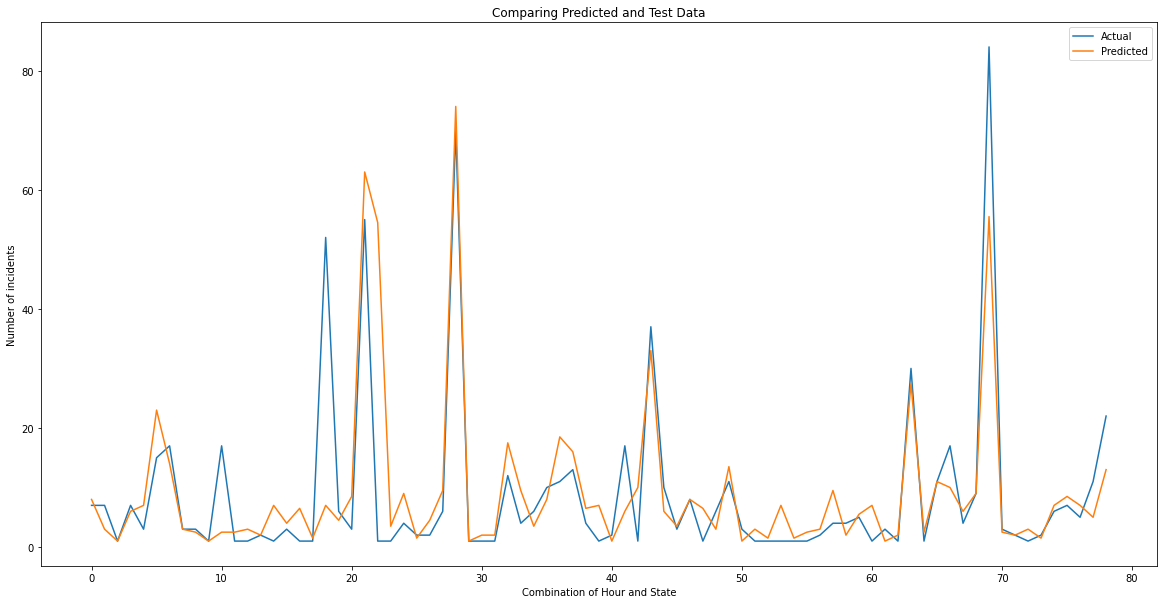

In [756]:
df_results = df_results.reset_index(drop=True)
df_results.head(200).plot(figsize = (20,10))
plt.title('Comparing Predicted and Test Data')
plt.xlabel('Combination of Hour and State')
plt.ylabel('Number of incidents')

We now calculate the correlation between the actual and predicted values.

In [706]:

act = df_results['Actual']
pred = df_results['Predicted']

print('Correlation is: {}'.format(act.corr(pred)))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(act, pred)
print('R^2 value: {}\nP Value: {}\nStandard Error: {}'.format(r_value, p_value, std_err))

Correlation is: 0.78433804448034
R^2 value: 0.7843380444803401
P Value: 1.2346883252204964e-17
Standard Error: 0.0643753361598501


We sort the list of attacks to show the highest combination of hour and State.

In [742]:
df_clean = df[['hour', 'STATE']].copy()
df_clean = df_clean.dropna(axis=0)
df_clean = df_clean.groupby(['hour', 'STATE']).size().reset_index(name='Count')
df_clean.sort_values(by='Count', ascending=False).head(15)

hour       STATE  Count
173     4  California    212
127     3  California    162
217     5  California    161
254     6  California    128
114     2       Texas    108
82      2     Florida     97
68      1       Texas     89
77      2  California     87
41      1     Florida     84
162     3       Texas     70
132     3     Florida     55
280     7  California     53
6       0     Florida     52
206     4       Texas     40
36      1  California     39